In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from src.data.analyse import *
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [62]:
# Load results
results = load_results('../results/scenarios=100, policies=20.tar.gz')

# Prepare outcomes data frame
outcomes = prepare_outcomes(results, add_policies=True)

# This outcome should be studied separately
outcomes.drop('years_in_poverty', axis=1, inplace=True)

# Convert columns of interest to float
for col in outcomes.columns:
    if col not in ['scenario', 'policy', 'district', 'my_policy']:
        outcomes[col] = outcomes[col].astype(float)

## EDA

In [63]:
outcomes[['target_group', 'top_up']] = outcomes['my_policy'].str.split('+', expand=True)
outcomes['top_up'] = pd.Categorical(outcomes['top_up'], categories=['0', '10', '30', '50', '100'])
outcomes['annual_average_consumption_loss_pct'] = outcomes['annual_average_consumption_loss_pct'] * 100
outcomes['initial_poverty_gap'] = outcomes['initial_poverty_gap'] * 100
outcomes['new_poverty_gap'] = outcomes['new_poverty_gap'] * 100
outcomes = outcomes.assign(n_new_poor_increase_pct = outcomes['n_new_poor'].div(outcomes['total_population']).multiply(100))

In [64]:
policies = ['0', '10', '30', '50', '100']
target_groups = [
                 'all', 
                 'poor', 
                 'poor_near_poor1.25', 
                 'poor_near_poor2.0'
                 ]
table = {}
for target_group in target_groups:
    d = {}
    for policy in policies:
        df = outcomes[outcomes['top_up'] == policy]
        df = df[df['target_group'] == target_group]
        columns_of_interest = ['district', 'n_poor_initial', 'n_new_poor']
        df.round(2)[columns_of_interest].groupby('district').median()
        d[policy] = (df['n_new_poor'].sum() / df['n_poor_initial'].sum() * 100)
    table[target_group] = d

In [ ]:
vertical = ['None', '10%', '30%', '50%', '100%']
horizontal = ['All', 'Poor', 'Poor & Near Poor (1.25)', 'Poor & Near Poor (2.0)']
columns = ['Vertical expansion', 'Horizontal expansion', 
           'Average reduction in consumption loss (%)', 
           'Average number of people prevented from falling into poverty']

In [65]:
table = pd.DataFrame(table).round(2)
table

,all,poor,poor_near_poor1.25,poor_near_poor2.0
0,3.44,3.44,3.44,3.44
10,3.32,3.44,3.40,3.35
30,3.10,3.44,3.35,3.16
50,2.89,3.44,3.31,2.99
100,2.24,3.44,3.11,2.41


In [66]:
# When top up == 0 it doesn't matter what is the target group
# df = outcomes[outcomes['top_up'] == '0']
df = outcomes.copy()
df = df[df['district'] == 'AnseLaRayeCanaries']
# df = df[df['target_group'] == 'all']
columns_of_interest = [
       'district',
       'target_group',
       'top_up', 
      #  'total_population',
      #  'total_asset_loss', 'total_consumption_loss', 'event_damage',
      #  'total_asset_stock', 'average_productivity', 'total_asset_in_survey',
      #  'expected_loss_fraction', 
      #  'n_affected_people',
      #  'annual_average_consumption', 'poverty_line_adjusted', 'pml', 
      #  'n_poor_initial', 'n_poor_affected', 
       'n_new_poor',
       'n_new_poor_increase_pct', 
       'initial_poverty_gap', 
       'new_poverty_gap', 
      #  'annual_average_consumption_loss',
       'annual_average_consumption_loss_pct', 
       'r'
       ]
df[columns_of_interest].round(2).groupby(['target_group', 'top_up', 'district']).mean()

n_new_poor  \
target_group       top_up district                         
all                0      AnseLaRayeCanaries       78.80   
                   10     AnseLaRayeCanaries       72.94   
                   30     AnseLaRayeCanaries       70.66   
                   50     AnseLaRayeCanaries       68.49   
                   100    AnseLaRayeCanaries       49.86   
poor               0      AnseLaRayeCanaries       78.80   
                   10     AnseLaRayeCanaries       78.80   
                   30     AnseLaRayeCanaries       78.80   
                   50     AnseLaRayeCanaries       78.80   
                   100    AnseLaRayeCanaries       78.80   
poor_near_poor1.25 0      AnseLaRayeCanaries       78.80   
                   10     AnseLaRayeCanaries       74.11   
                   30     AnseLaRayeCanaries       74.11   
                   50     AnseLaRayeCanaries       73.34   
                   100    AnseLaRayeCanaries       66.71   
poor_near_poor2.0  0      AnseLaRayeCanaries       78.80   
                   10     AnseLaRayeCanaries       72.94   
                   30     AnseLaRayeCanaries       71.08   
                   50     AnseLaRayeCanaries       68.91   
                   100    AnseLaRayeCanaries       50.28   

                                              n_new_poor_increase_pct  \
target_group       top_up district                                      
all                0      AnseLaRayeCanaries                   0.9092   
                   10     AnseLaRayeCanaries                   0.8415   
                   30     AnseLaRayeCanaries                   0.8152   
                   50     AnseLaRayeCanaries                   0.7901   
                   100    AnseLaRayeCanaries                   0.5751   
poor               0      AnseLaRayeCanaries                   0.9092   
                   10     AnseLaRayeCanaries                   0.9092   
                   30     AnseLaRayeCanaries                   0.9092   
                   50     AnseLaRayeCanaries                   0.9092   
                   100    AnseLaRayeCanaries                   0.9092   
poor_near_poor1.25 0      AnseLaRayeCanaries                   0.9092   
                   10     AnseLaRayeCanaries                   0.8550   
                   30     AnseLaRayeCanaries                   0.8550   
                   50     AnseLaRayeCanaries                   0.8461   
                   100    AnseLaRayeCanaries                   0.7697   
poor_near_poor2.0  0      AnseLaRayeCanaries                   0.9092   
                   10     AnseLaRayeCanaries                   0.8415   
                   30     AnseLaRayeCanaries                   0.8200   
                   50     AnseLaRayeCanaries                   0.7949   
                   100    AnseLaRayeCanaries                   0.5799   

                                              initial_poverty_gap  \
target_group       top_up district                                  
all                0      AnseLaRayeCanaries                32.85   
                   10     AnseLaRayeCanaries                32.85   
                   30     AnseLaRayeCanaries                32.85   
                   50     AnseLaRayeCanaries                32.85   
                   100    AnseLaRayeCanaries                32.85   
poor               0      AnseLaRayeCanaries                32.85   
                   10     AnseLaRayeCanaries                32.85   
                   30     AnseLaRayeCanaries                32.85   
                   50     AnseLaRayeCanaries                32.85   
                   100    AnseLaRayeCanaries                32.85   
poor_near_poor1.25 0      AnseLaRayeCanaries                32.85   
                   10     AnseLaRayeCanaries                32.85   
                   30     AnseLaRayeCanaries                32.85   
                   50     AnseLaRayeCanaries                32.85   
              

In [71]:
target_group_names = {'all' : 'All', 'poor' : 'Poor', 'poor_near_poor1.25' : 'Poor and near-poor (1.25)', 'poor_near_poor2.0' : 'Poor and near-poor (2.0)'}
target_group = 'all'
df = outcomes[outcomes['target_group'] == target_group]

districts = df['district'].unique().tolist()
n_districts = len(districts)

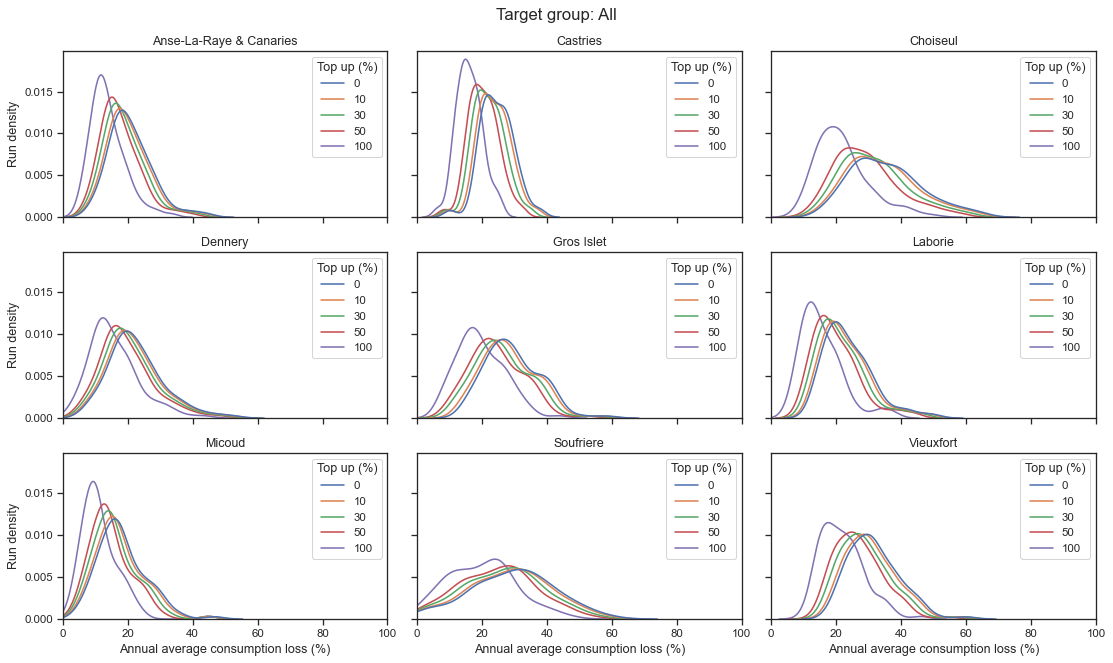

In [82]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'
outcome_of_interest = 'annual_average_consumption_loss_pct'
outcome_to_outcome_name = {'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)',
                           'n_new_poor': 'Number of new poor',
                           'n_new_poor_increase_pct' : 'Increase in number of new poor (%)'}

for district in districts:
    data = df[df['district'] == district][['top_up', outcome_of_interest]]
    data.sort_values('top_up', inplace=True)
    data.rename(columns={'top_up': 'Top up (%)'}, inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    # sns.histplot(data=data, 
    #              x=outcome_of_interest, 
    #              hue='Top up', 
    #              ax=ax[i, j], 
    #              # multiple='stack', 
    #              # shrink=.8,
    #              # palette="ch:rot=-.25,hue=1,light=.75"
    #              )
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up (%)', 
                 ax=ax[i, j], 
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_ylabel('Run density')
    ax[i, j].set_xlabel(outcome_to_outcome_name[outcome_of_interest])
    ax[i, j].set_xlim(0, 100)
fig.suptitle('Target group: ' + target_group_names[target_group], fontsize=16)
fig.tight_layout()